# Exploring various regression models

## In this notebook, we predominantly look at different variations of models, with inividual predictors, like HAQ and SDI and also with their interaction effects with some of the qualitative variables such as Age Group and Sex. This analysis was done on the previously generated data (GBD round 4) just to see what the models suggested.

### The purpose of this notebook is to generate predictions for DALYs when HAQ over frontier is set to 0

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import datasets
import pandas.io.sql as psql
#from sqlalchemy import create_engine
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from numpy import sign, abs, log10
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Necessary imports for k-fold cross-validation: 
#from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

#import pygam
#from pygam import LinearGAM

In [3]:
# Read in HAQ-SDI frontier results
df = pd.read_csv('/ihme/homes/arjuns13/notebooks/Documents/code_from_Kate/haq_sdi_frontier_estimates.csv')

In [4]:
df.head()

,Unnamed: 0,V1,location_id,logit_sdi,age_group_id,ln_haq,fit2
0,1,0,6,0.905187,2,1.774982,1.868374
1,2,18,7,0.110348,2,1.628882,1.732993
2,3,36,8,1.820419,2,1.940303,2.024261
3,4,54,10,-0.093432,2,1.588596,1.698284
4,5,72,11,0.537233,2,1.601596,1.805702


In [5]:
len(df['location_id'].unique())

195

In [6]:
### For ages above 70 (age group ID >= 19), set HAQ over frontier to 1

In [7]:
nineteen = df[df['age_group_id'] == 19]

In [8]:
twenty = nineteen.copy()

In [9]:
twenty['age_group_id'] = 20
twenty['ln_haq'] = 1
twenty['fit2'] = 1

In [10]:
thirty = nineteen.copy()
thirty['age_group_id'] = 30
thirty['ln_haq'] = 1
thirty['fit2'] = 1

In [11]:
thirty_one = nineteen.copy()
thirty_one['age_group_id'] = 31
thirty_one['ln_haq'] = 1
thirty_one['fit2'] = 1

In [12]:
thirty_two = nineteen.copy()
thirty_two['age_group_id'] = 32
thirty_one['ln_haq'] = 1
thirty_one['fit2'] = 1

In [13]:
two_three_five = nineteen.copy()
two_three_five['age_group_id'] = 235
two_three_five['ln_haq'] = 1
two_three_five['fit2'] = 1

In [14]:
merged = pd.concat([df, twenty, thirty, thirty_one, thirty_two, two_three_five], axis=0)

In [15]:
print(df.shape)
print(nineteen.shape)

(3510, 7)
(195, 7)


In [16]:
merged.shape

(4485, 7)

In [17]:
merged['age_group_id'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  30,  31,  32, 235])

In [18]:
#merged[merged['age_group_id'] == 235]

In [19]:
merged.head()

,Unnamed: 0,V1,location_id,logit_sdi,age_group_id,ln_haq,fit2
0,1,0,6,0.905187,2,1.774982,1.868374
1,2,18,7,0.110348,2,1.628882,1.732993
2,3,36,8,1.820419,2,1.940303,2.024261
3,4,54,10,-0.093432,2,1.588596,1.698284
4,5,72,11,0.537233,2,1.601596,1.805702


# Import and merge DALYs data

In [20]:
#dalys = pd.read_csv('J:\\Project\\Cost_Effectiveness\\Access_to_care\\temp\\dalys_for_haq_by_age.csv')
dalys = pd.read_csv('/snfs1/Project/Cost_Effectiveness/Access_to_care/temp/dalys_for_haq_by_age.csv')

In [21]:
dalys.head()

,Unnamed: 0,location_id,age_group_id,sex_id,dalys,population,dalys_per_person
0,0,10,2,1,242166.880954,3812.46,63.519848
1,1,10,3,1,60192.200603,11333.55,5.310975
2,2,10,4,1,234034.428986,179784.33,1.301751
3,3,10,5,1,121342.140241,765976.00,0.158415
4,4,10,6,1,90082.196057,870462.00,0.103488


In [22]:
final = pd.merge(dalys, merged, on=['location_id', 'age_group_id'])

In [23]:
final.shape

(8970, 12)

In [24]:
final.head()

,Unnamed: 0_x,location_id,age_group_id,sex_id,dalys,population,dalys_per_person,Unnamed: 0_y,V1,logit_sdi,ln_haq,fit2
0,0,10,2,1,242166.880954,3812.46,63.519848,4,54,-0.093432,1.588596,1.698284
1,23,10,2,2,190983.580528,3638.45,52.490368,4,54,-0.093432,1.588596,1.698284
2,1,10,3,1,60192.200603,11333.55,5.310975,199,55,-0.093432,1.678949,1.741248
3,24,10,3,2,40855.666418,10834.02,3.771053,199,55,-0.093432,1.678949,1.741248
4,2,10,4,1,234034.428986,179784.33,1.301751,394,56,-0.093432,1.688785,1.732339


In [25]:
final['haq'] = 10**(final['ln_haq'])

## DALYs versus age-groups

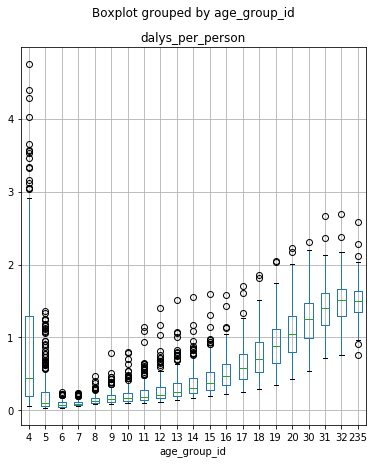

In [26]:
abcd = final[(final['age_group_id']!=2) & (final['age_group_id']!=3)]
dqbp = abcd.boxplot(column='dalys_per_person',by='age_group_id',figsize=(6,7))

## The below code shows that HAQ is always '10' for all cases where age-group_id is in (20,20,31)

In [27]:
final[(final['age_group_id']==20) | (final['age_group_id']==30) | (final['age_group_id']==31)].describe()

,Unnamed: 0_x,location_id,age_group_id,sex_id,dalys,population,dalys_per_person,Unnamed: 0_y,V1,logit_sdi,ln_haq,fit2,haq
count,1170.000000,1170.000000,1170.000000,1170.000000,1.170000e+03,1.170000e+03,1170.000000,1170.000000,1170.000000,1170.000000,1170.0,1170.0,1170.0
mean,4492.500000,125.010256,27.000000,1.500000,1.989450e+05,1.955469e+05,1.242589,3413.000000,1763.000000,0.637500,1.0,1.0,10.0
std,2590.514868,84.345799,4.968679,0.500214,8.046539e+05,7.767253e+05,0.352443,56.314982,1013.669684,0.848583,0.0,0.0,0.0
min,18.000000,6.000000,20.000000,1.000000,2.291826e+01,1.160000e+01,0.427365,3316.000000,17.000000,-1.423959,1.0,1.0,10.0
25%,2250.250000,60.000000,20.000000,1.000000,5.145772e+03,4.053340e+03,0.972056,3364.000000,881.000000,0.003273,1.0,1.0,10.0
50%,4492.500000,117.000000,30.000000,1.500000,3.137059e+04,2.709189e+04,1.241879,3413.000000,1763.000000,0.629143,1.0,1.0,10.0
75%,6734.750000,176.000000,31.000000,2.000000,1.091712e+05,9.927908e+04,1.483319,3462.000000,2645.000000,1.279282,1.0,1.0,10.0
max,8967.000000,522.000000,31.000000,2.000000,1.323474e+07,1.278864e+07,2.670350,3510.000000,3509.000000,2.420494,1.0,1.0,10.0


In [28]:
final['age_group_id'] = final.age_group_id.astype('category')

In [29]:
df_haq = final['haq']

In [30]:
haq_stats = df_haq.describe()
haq_stats

count    8970.000000
mean       51.834680
std        26.773972
min        10.000000
25%        30.918774
50%        54.888598
75%        72.902749
max        98.697928
Name: haq, dtype: float64

## finding the various quartiles for HAQ for us to help visualize better

In [31]:
low = np.floor(round(haq_stats['min']))
q1 = round(haq_stats['25%'])
q2 = round(haq_stats['50%'])
q3 = round(haq_stats['75%'])
high = np.ceil(round(haq_stats['max']))

## First quartile

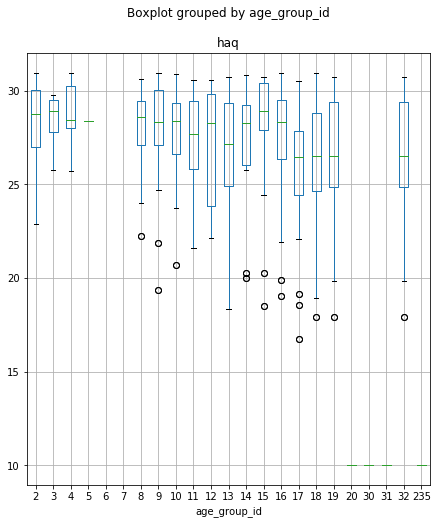

In [32]:
first_q = final[final['haq']<=q1]
fqbp = first_q.boxplot(column='haq',by='age_group_id',figsize=(7,8))

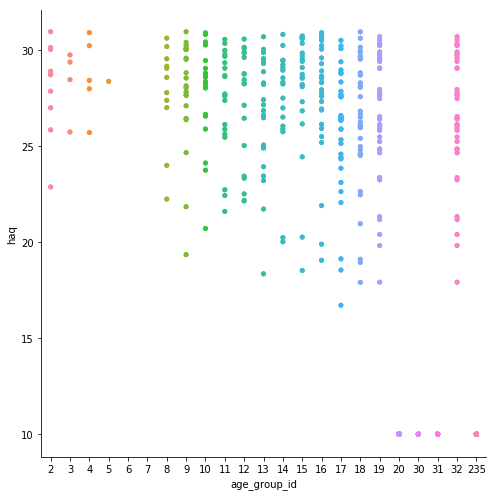

In [33]:
import seaborn as sns
cp = sns.catplot(x="age_group_id", y="haq", data=first_q,jitter=False,height=7, aspect=1)

## Second quartile

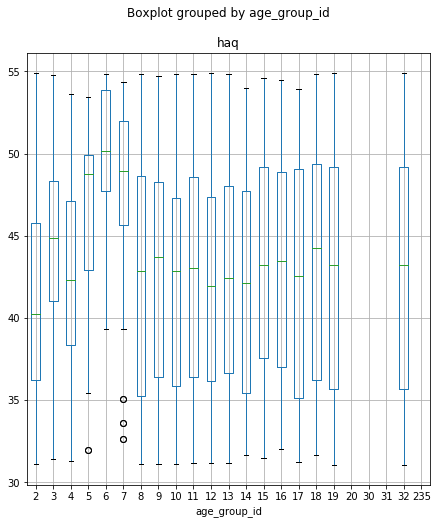

In [34]:
second_q = final[(final['haq']>q1) & (final['haq']<=q2)]
sqbp = second_q.boxplot(column='haq',by='age_group_id',figsize=(7,8))

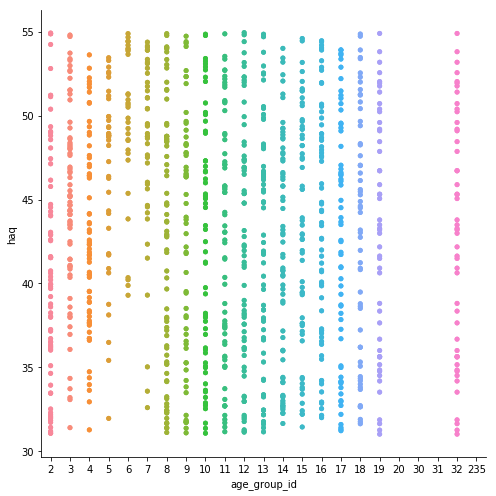

In [35]:
cp2 = sns.catplot(x="age_group_id", y="haq", data=second_q,jitter=False,height=7, aspect=1)

## Third quartile

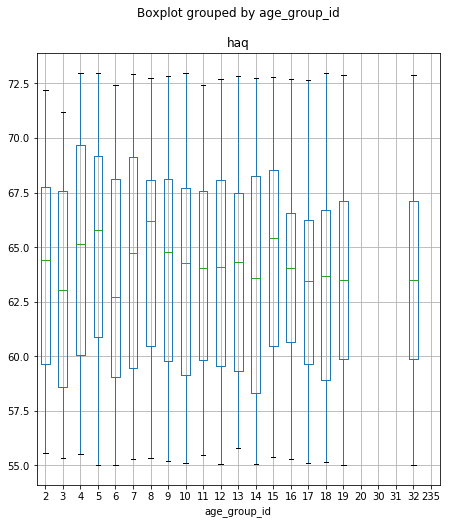

In [36]:
third_q = final[(final['haq']>q2) & (final['haq']<=q3)]
tqbp = third_q.boxplot(column='haq',by='age_group_id',figsize=(7,8))

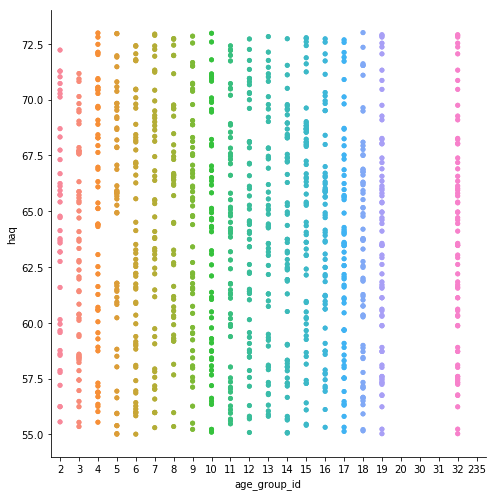

In [37]:
cp3 = sns.catplot(x="age_group_id", y="haq", data=third_q,jitter=False,height=7, aspect=1)

## fourth quartile

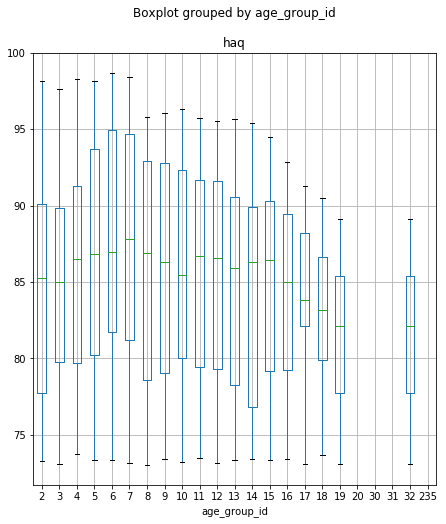

In [38]:
fourth_q = final[final['haq']>q3]
tqbp = fourth_q.boxplot(column='haq',by='age_group_id',figsize=(7,8))

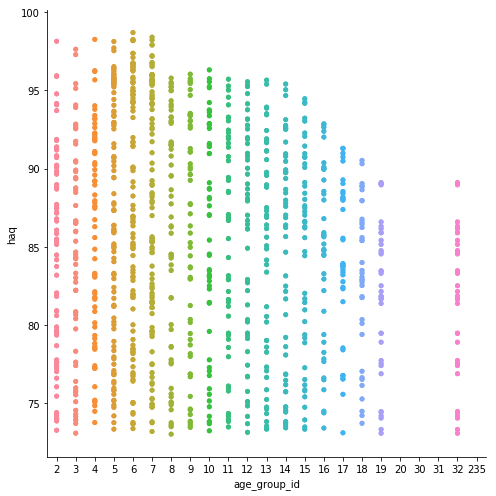

In [39]:
cp4 = sns.catplot(x="age_group_id", y="haq", data=fourth_q,jitter=False,height=7, aspect=1)

## Now analyzing the HAQ_over_Frontier values per age-groups

## the fit is also in a log scale cause the fit is nothing but the most optimal HAQ for a given SDI level

In [40]:
final['exp_fit'] = 10**(final['fit2'])

In [41]:
final['exp_fit'].describe()

count    8970.000000
mean       59.188869
std        30.506666
min        10.000000
25%        40.951881
50%        60.896141
75%        79.472822
max       134.159598
Name: exp_fit, dtype: float64

In [42]:
final.loc[final['exp_fit'] > 100.0, 'exp_fit']=100


In [43]:
final['exp_fit'].describe()

count    8970.000000
mean       58.105326
std        28.685007
min        10.000000
25%        40.951881
50%        60.896141
75%        79.472822
max       100.000000
Name: exp_fit, dtype: float64

In [44]:
final['haq_over_frontier'] = final['haq']/final['exp_fit']

In [45]:
final[final['haq_over_frontier']==1].age_group_id.unique() ## make sure that HAQ over frontier = 1 for age group IDs > 19

[20, 30, 31, 235]
Categories (4, int64): [20, 30, 31, 235]

In [46]:
final.head()

,Unnamed: 0_x,location_id,age_group_id,sex_id,dalys,population,dalys_per_person,Unnamed: 0_y,V1,logit_sdi,ln_haq,fit2,haq,exp_fit,haq_over_frontier
0,0,10,2,1,242166.880954,3812.46,63.519848,4,54,-0.093432,1.588596,1.698284,38.778929,49.921131,0.776804
1,23,10,2,2,190983.580528,3638.45,52.490368,4,54,-0.093432,1.588596,1.698284,38.778929,49.921131,0.776804
2,1,10,3,1,60192.200603,11333.55,5.310975,199,55,-0.093432,1.678949,1.741248,47.747293,55.112211,0.866365
3,24,10,3,2,40855.666418,10834.02,3.771053,199,55,-0.093432,1.678949,1.741248,47.747293,55.112211,0.866365
4,2,10,4,1,234034.428986,179784.33,1.301751,394,56,-0.093432,1.688785,1.732339,48.841025,53.993158,0.904578


In [47]:
df_haq_frontier = final['haq_over_frontier']

## Can be seen below that the HAQ/Frontier values don't max at 1. May be a problem:

In [48]:
haq_frontier_stats = df_haq_frontier.describe()
haq_frontier_stats

count    8970.000000
mean        0.902110
std         0.124347
min         0.449313
25%         0.828224
50%         0.920186
75%         1.000000
max         1.369880
Name: haq_over_frontier, dtype: float64

## HAQ over frontier Versus age-group-ids

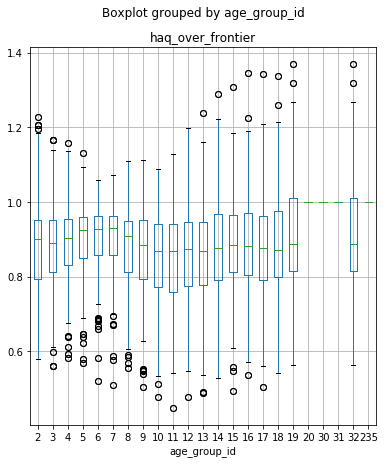

In [49]:
fqbp = final.boxplot(column='haq_over_frontier',by='age_group_id',figsize=(6,7))

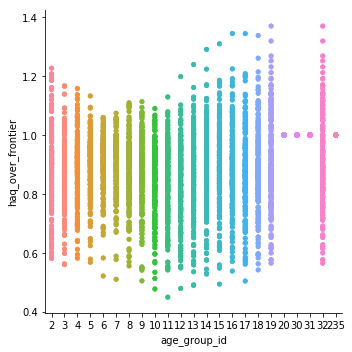

In [50]:
cp = sns.catplot(x="age_group_id", y="haq_over_frontier", data=final,jitter=False,height=5, aspect=1)

## DALYSperCapita versus age_groups

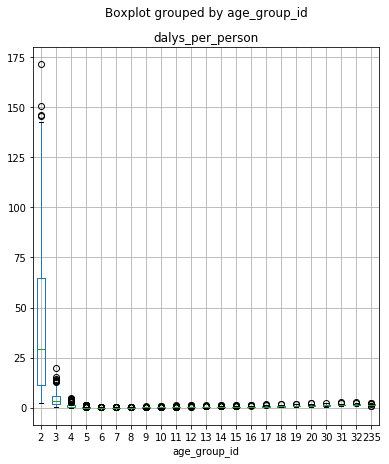

In [51]:
fqbp = final.boxplot(column='dalys_per_person',by='age_group_id',figsize=(6,7))

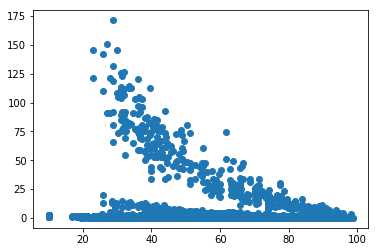

In [52]:
pshd = plt.scatter(final['haq'],final['dalys_per_person'])

In [53]:
final['age_group_id'] = pd.to_numeric(final['age_group_id'])

In [54]:
data_test = final.loc[~final['age_group_id'].isin([2,3,20,30,31,235])]

In [55]:
data_test['age_group_id'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 32])

In [56]:
#cphdab = sns.catplot(x="haq",y="dalys_per_person",data=data_test,jitter=False)

In [57]:
data_test.head()

,Unnamed: 0_x,location_id,age_group_id,sex_id,dalys,population,dalys_per_person,Unnamed: 0_y,V1,logit_sdi,ln_haq,fit2,haq,exp_fit,haq_over_frontier
4,2,10,4,1,234034.428986,179784.33,1.301751,394,56,-0.093432,1.688785,1.732339,48.841025,53.993158,0.904578
5,25,10,4,2,161209.830863,172281.88,0.935733,394,56,-0.093432,1.688785,1.732339,48.841025,53.993158,0.904578
6,3,10,5,1,121342.140241,765976.00,0.158415,589,57,-0.093432,1.812518,1.813794,64.940854,65.131959,0.997066
7,26,10,5,2,105455.557684,736141.69,0.143254,589,57,-0.093432,1.812518,1.813794,64.940854,65.131959,0.997066
8,4,10,6,1,90082.196057,870462.00,0.103488,784,58,-0.093432,1.826951,1.839046,67.135300,69.031264,0.972535


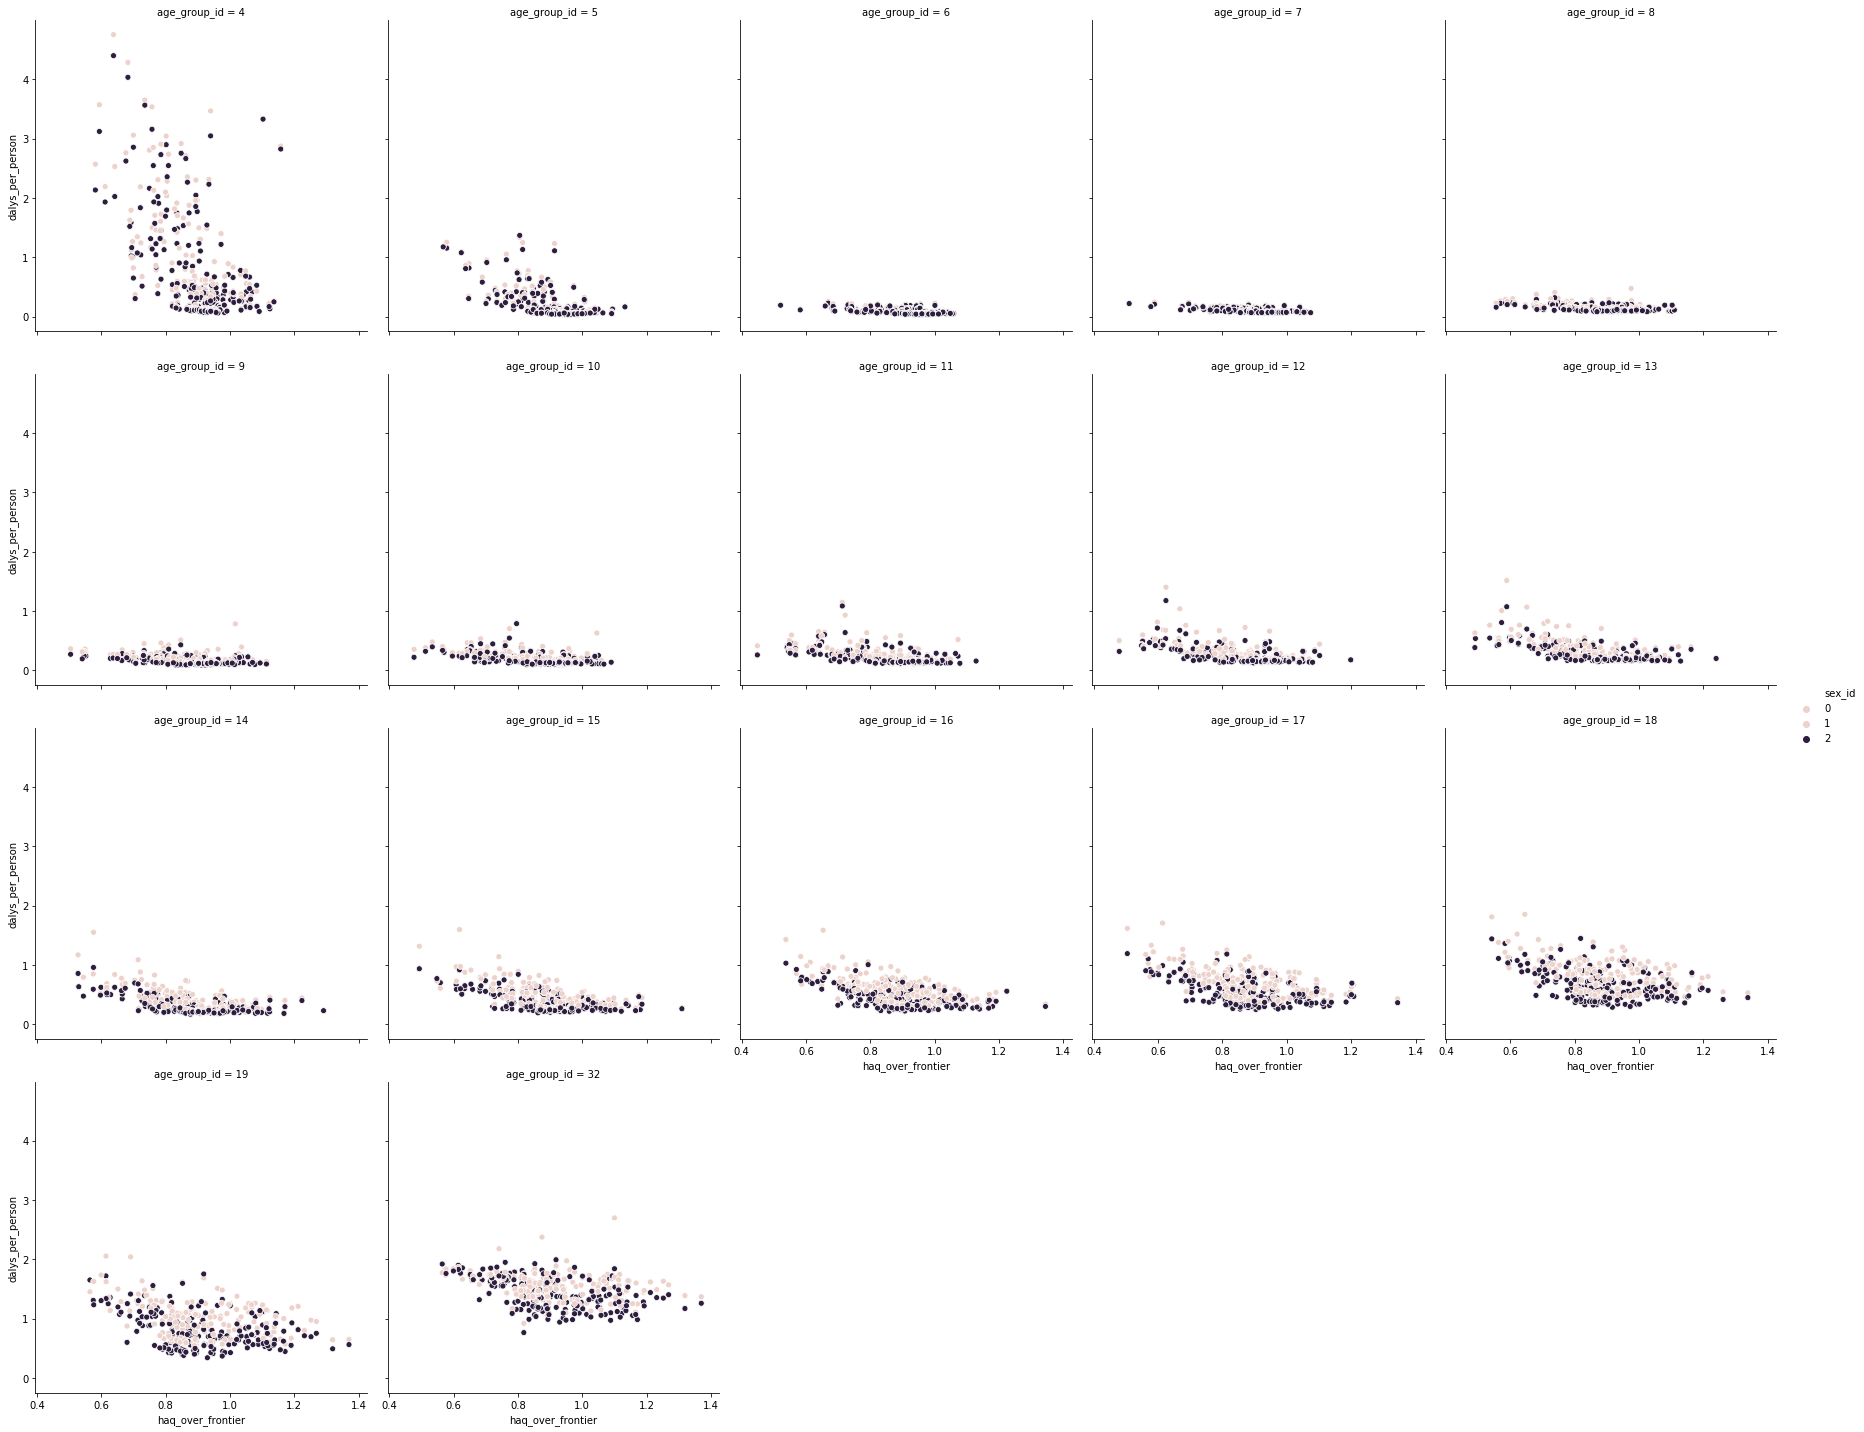

In [58]:
cphofda = sns.relplot(x="haq_over_frontier",y="dalys_per_person",col="age_group_id",kind="scatter",col_wrap=5,hue="sex_id",data=data_test)

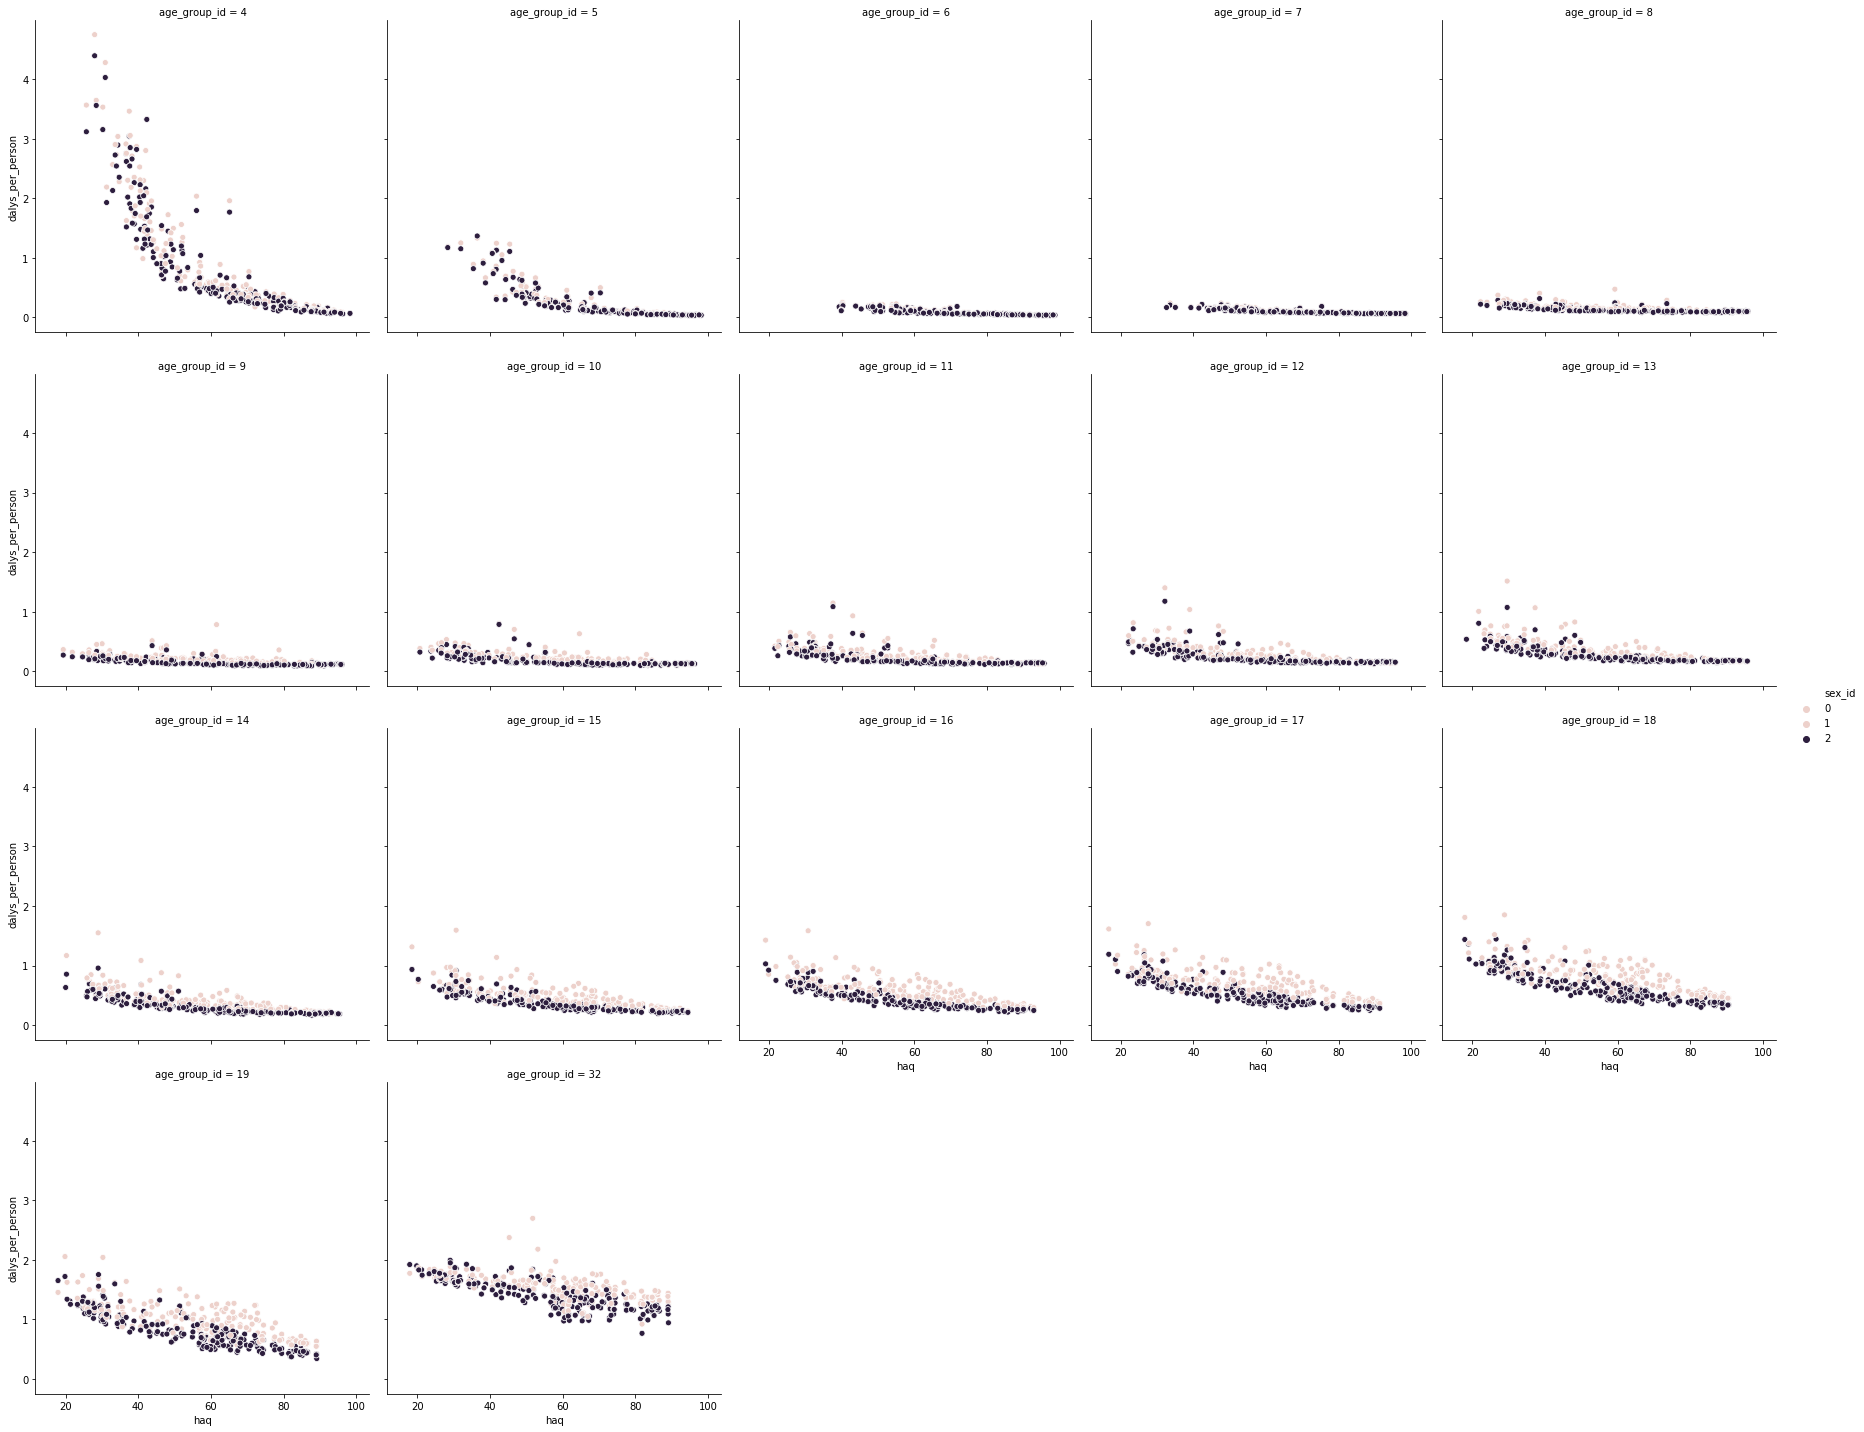

In [67]:
cphda2 = sns.relplot(x="haq",y="dalys_per_person",col="age_group_id",col_wrap=5,hue="sex_id",data=data_test)

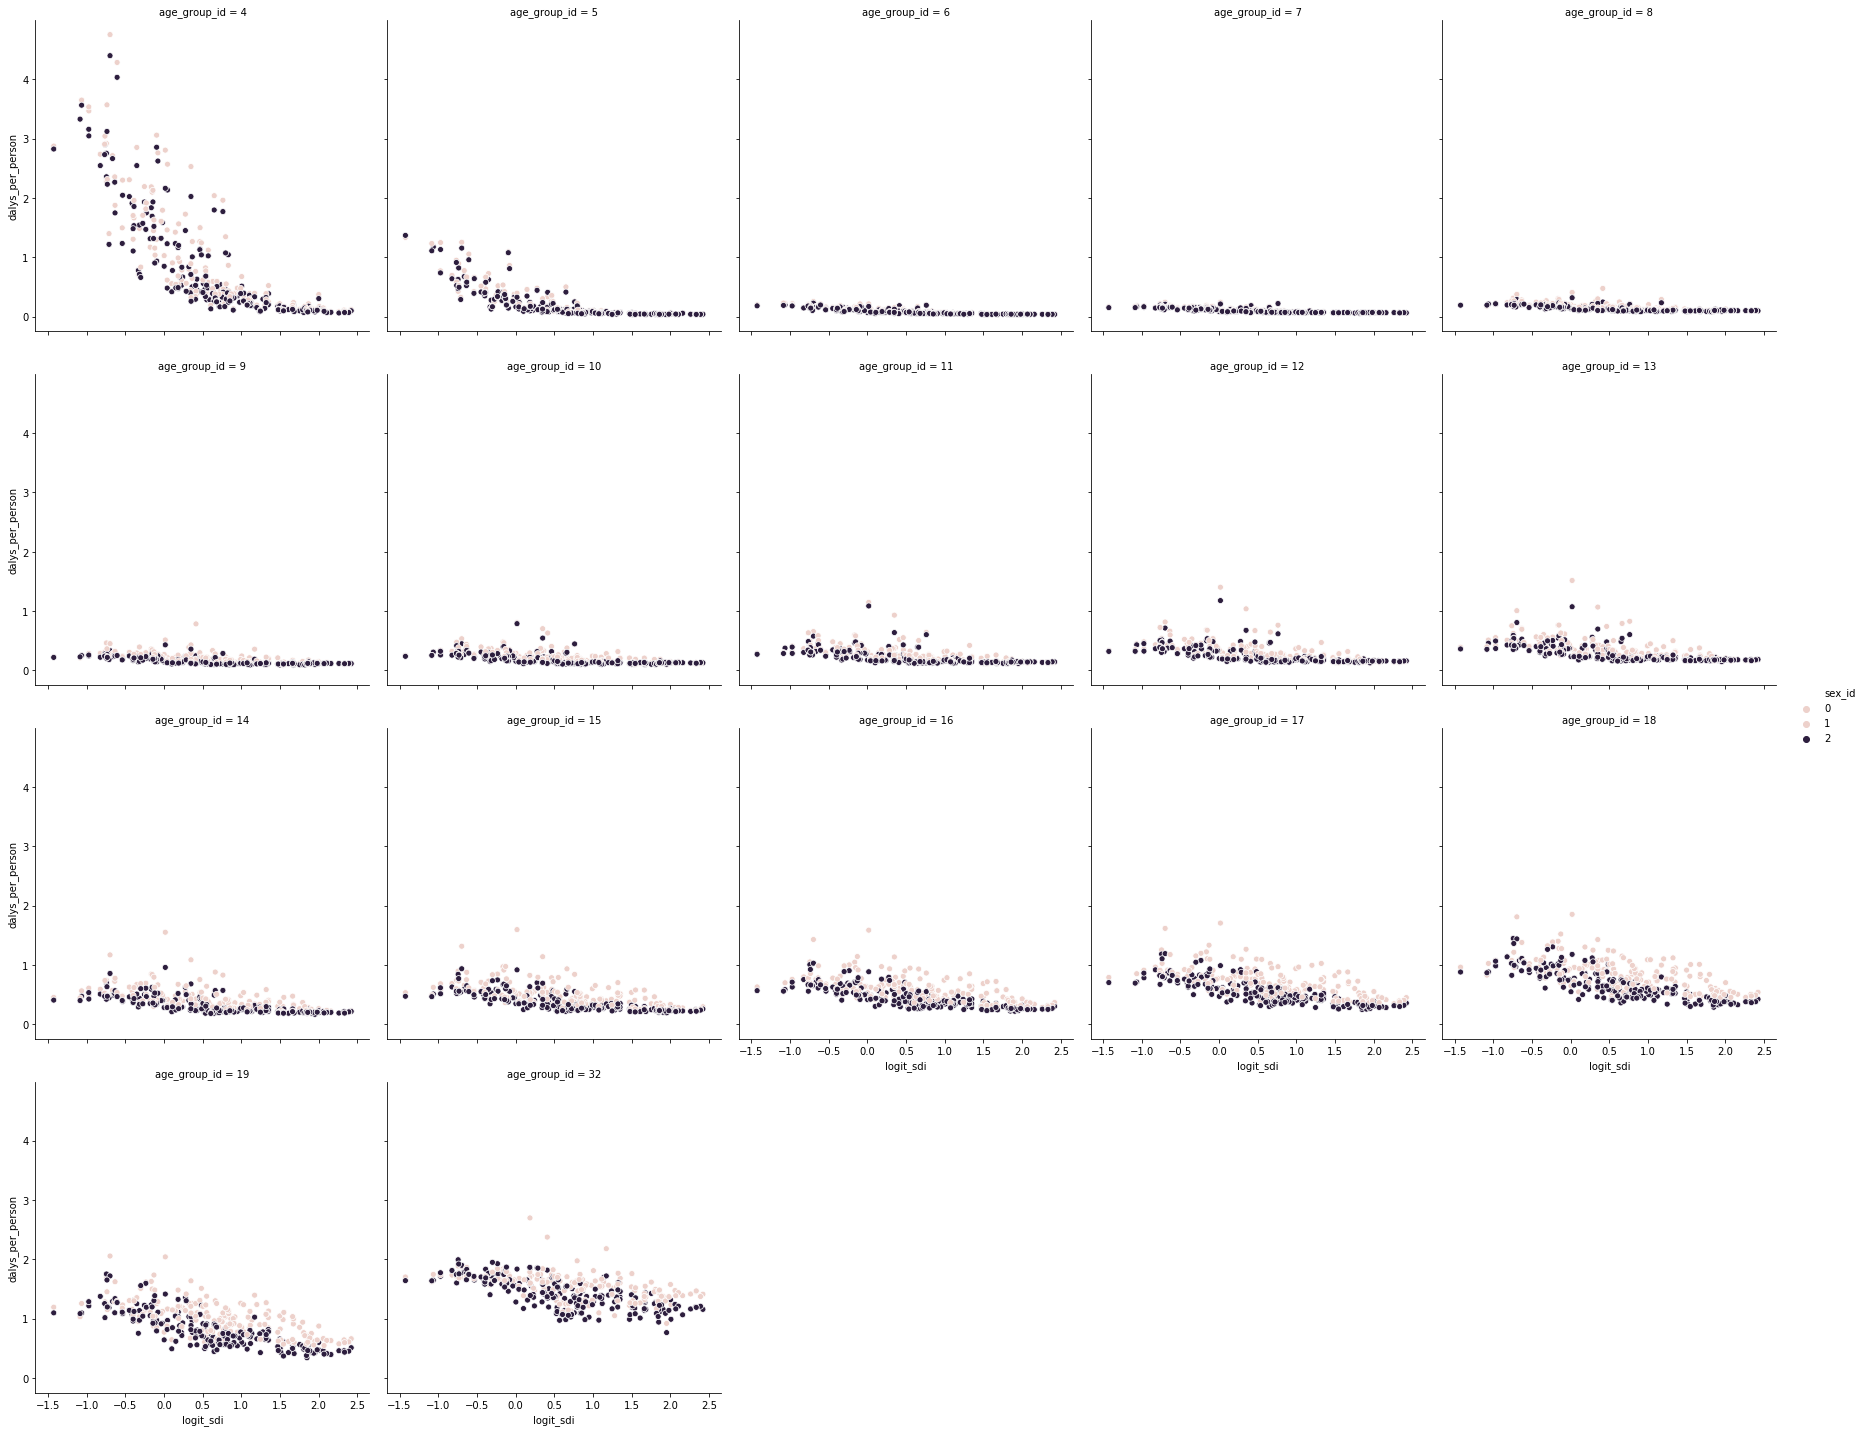

In [68]:
cphda3 = sns.relplot(x="logit_sdi",y="dalys_per_person",col="age_group_id",col_wrap=5,hue="sex_id",data=data_test)

# Create dataframes for each age-sex group

In [ ]:
grouped =  dict(tuple(final.groupby(['age_group_id', 'sex_id'])))

In [ ]:
len(final['age_group_id'].unique()) * len(final['sex_id'].unique())*195

In [ ]:
grouped[2,2].shape

In [ ]:
grouped[7, 2]

In [ ]:
for g in grouped:
    print(g)

# Plot frontiers

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

#pdf = matplotlib.backends.backend_pdf.PdfPages('/share/scratch/users/krosett/DCPN data/HAQ_frontier_by_age.pdf')

#for g in grouped:

df = grouped[10, 2]

plt.plot(df.logit_sdi, df['haq'], 'o', label='age-specific estimates for age ID, sex ID {}'.format(g))
plt.plot(df.logit_sdi, df['exp_fit'], 'x', label= 'frontier estimates for age ID, sex ID {}'.format(g))
plt.xlabel('logit SDI')
plt.ylabel('HAQ')
plt.legend(bbox_to_anchor=(1, 1))
    #pdf.savefig()
#plt.savefig("/share/scratch/users/krosett/DCPN data/quintile_plot_ip_gdp_linear_spline.pdf", bbox_inches='tight')
#pdf.close()

## Here is some of myown attempts

In [ ]:
final.head()

In [ ]:
data_ver1 = final[['age_group_id','sex_id','dalys_per_person','haq_over_frontier','logit_sdi']]# will add 'location_id', later on

In [ ]:
data_ver1.head()
data_ver1.info()

In [ ]:
data_ageGroup_5_to_8 = data_ver1.copy()
data_ageGroup_5_to_8_new = data_ageGroup_5_to_8[(data_ageGroup_5_to_8['age_group_id']==5) | (data_ageGroup_5_to_8['age_group_id']==6) | (data_ageGroup_5_to_8['age_group_id']==7)]
data_ageGroup_5_to_8_new.head(36)

In [ ]:
data_ageGroup_5_to_8 = data_ver1.copy()
data_ageGroup_5_to_8['age_group_id'] = pd.to_numeric(data_ageGroup_5_to_8['age_group_id'])

data_ageGroup_5_to_8_new = data_ageGroup_5_to_8.loc[data_ageGroup_5_to_8['age_group_id'].isin([5,6,7,8])]
data_ageGroup_5_to_8_new.head(36)

In [ ]:
data_ageGroup_6_to_9 = data_ver1.copy()
data_ageGroup_6_to_9['age_group_id'] = pd.to_numeric(data_ageGroup_6_to_9['age_group_id'])

data_ageGroup_6_to_9_new = data_ageGroup_6_to_9.loc[data_ageGroup_6_to_9['age_group_id'].isin([6,7,8,9])]
data_ageGroup_6_to_9_new.head(16)

In [ ]:
linear_reg = smf.ols("dalys_per_person ~ logit_sdi + haq_over_frontier + C(sex_id) + C(age_group_id) + C(sex_id):C(age_group_id) + logit_sdi:C(age_group_id) + haq_over_frontier:C(age_group_id)", data = data_ageGroup_6_to_9_new)
linear_reg_fit = linear_reg.fit()
print(linear_reg_fit.summary())

In [ ]:
linear_reg = smf.ols("dalys_per_person ~ logit_sdi + haq_over_frontier + C(sex_id) + C(age_group_id) + C(sex_id):C(age_group_id) + logit_sdi:C(age_group_id) + haq_over_frontier:C(age_group_id)", data = data_ageGroup_5_to_8_new)
linear_reg_fit = linear_reg.fit()
print(linear_reg_fit.summary())

In [ ]:
linear_reg = smf.ols("dalys_per_person ~ logit_sdi*C(sex_id)*C(age_group_id) + haq_over_frontier*C(sex_id)*C(age_group_id)", data = data_ageGroup_6_to_9_new)
linear_reg_fit = linear_reg.fit()
print(linear_reg_fit.summary())

In [ ]:
#data_ageGroup_5_to_8_withDummies_ne = 
#data_ageGroup_5_to_8_withDummies_new = pd.DataFrame(data_ageGroup_5_to_8_new)
data_ageGroup_5_to_8_withDummies_new = pd.get_dummies(data_ageGroup_5_to_8_new,columns=['age_group_id'],drop_first=True)
data_ageGroup_5_to_8_withDummies_new.head()

In [ ]:
data_ageGroup_5_to_8_new.info()

In [ ]:
data_ageGroup_5_to_8_new.describe()

In [ ]:
data_ver2 = pd.get_dummies(data_ver1,columns=['age_group_id','sex_id'])

In [ ]:
data_ver2.head()

In [ ]:
response = data_ver2['dalys_per_person'];
predictors = data_ver2.drop(['dalys_per_person'],axis=1);                  

#from sklearn.cross_validation import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(Features,ActualPrices, test_size = 0.30, random_state=2);


#trying something else here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

steps = [
    #('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(predictors, response)

print('Training score: {}'.format(pipeline.score(predictors, response)))
#print('Test score: {}'.format(pipeline.score(x_test, y_test)))
#y_pred = pipeline.predict(x_test)

In [ ]:
response = data_ver2['dalys_per_person'];
predictors = data_ver2.drop(['dalys_per_person'],axis=1);                  

#from sklearn.cross_validation import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(Features,ActualPrices, test_size = 0.30, random_state=2);


#trying something else here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(predictors)

reg = LinearRegression().fit(X,response)
print('Training score: {}'.format(reg.score(X, response)))

In [ ]:
len(reg.coef_)

poly.n_output_features_

In [ ]:
#from sklearn.preprocessing import StandardScaler
#scalar = StandardScaler()
#X = scalar.fit_transform(predictors)
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.01).fit(predictors,response)
print('Training score: {}'.format(reg.score(predictors, response)))

In [ ]:
len(reg.coef_)

In [ ]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 1000, max_depth = 15, min_samples_split = 2, learning_rate = 0.1, loss = 'lad')
clf.fit(predictors, response)
print('Training score: {}'.format(clf.score(predictors, response)))

In [ ]:
tree = clf.estimators_[0, 0].tree_
leaf_mask = tree.children_left == -1  # TREE_LEAF == -1
w_i = tree.value[leaf_mask, 0, 0]
#w_i

In [ ]:
len(w_i)

In [ ]:
#clf.estimators_

In [ ]:
len(clf.feature_importances_)

## also, if we end up standardizing/normalizing, we won't need the intercept term

## The model below basically captures a lot of what the groups were trying to achieve without the clutter

In [ ]:
#data_ver1.iloc[1:100,:]

### Runing the regression only for age groups 5,6,7,8

In [ ]:
linear_reg = smf.ols("dalys_per_person ~ logit_sdi:C(sex_id) + logit_sdi:C(age_group_id) + haq_over_frontier:C(sex_id) + haq_over_frontier:C(age_group_id)", data = data_ver1)
linear_reg_fit = linear_reg.fit()
print(linear_reg_fit.summary())

In [ ]:
dbp = data_ver1[data_ver1.age_group_id!=2].boxplot(column='dalys_per_person',by='age_group_id',figsize=(7,8))

In [ ]:
dbp = data_ver1.boxplot(column='dalys_per_person',by='age_group_id',figsize=(7,8))

In [ ]:
len(linear_reg_fit.params)

In [ ]:
for g in grouped:
    df=grouped[g]
    linear_reg = smf.ols("dalys_per_person ~ haq_over_frontier + logit_sdi", \
                      data = df)
    linear_reg_fit = linear_reg.fit()
    print(linear_reg_fit.summary(), g)
    df['predictions_xtest_linear'] = linear_reg_fit.predict(grouped[g])
    df['residuals'] = df['dalys_per_person'] - df['predictions_xtest_linear']
    df['predictions_counterfactual'] = (linear_reg_fit.predict(grouped_for_predictions[g]))
    df['counterfactual_dalys_total'] = (df['predictions_counterfactual'] + df['residuals']) * df['population']
    df['ratio'] = df['counterfactual_dalys_total']/df['dalys']
    
    df['intercept'] = linear_reg_fit.params[0]
    df['haq_over_frontier_coef'] = linear_reg_fit.params[1]
    df['sdi_coef'] = linear_reg_fit.params[2]
    df['r2'] = linear_reg_fit.rsquared
    
    predictions = linear_reg_fit.get_prediction(grouped_for_predictions[g])
    predictions_df = predictions.summary_frame(alpha=0.05).sort_index()
    
    df2 = df.reset_index()
    df3 = pd.merge(df2, predictions_df, left_index=True, right_index=True)
    df3 = df3.set_index('index')
    df['se'] = df3['mean_se']
    df['mean'] = df3['mean']

## This is the end of my own attempts

# Set HAQ frontier to 0 for predictions dataframe

In [ ]:
# Create df for predictions where haq_frontier is set to 0
df_predictions = final.copy()
df_predictions['haq_over_frontier'] = 0
df_predictions.head()

In [ ]:
grouped_for_predictions =  dict(tuple(df_predictions.groupby(['age_group_id', 'sex_id'])))

In [ ]:
grouped_for_predictions[2, 2].head()

# Evaluate correlations between outcome and covariates

In [ ]:
import seaborn as sns
for g in grouped:
    df=grouped[g]
    df_filtered = df[['dalys_per_person','haq_over_frontier', 'logit_sdi']]
    corr = df_filtered.corr()
    print(corr, g)

In [ ]:
# correlations for all age-sex combined

df_filtered = final[['dalys_per_person','haq_over_frontier', 'logit_sdi']]
corr = df_filtered.corr()
print(corr)

# for each age-sex group, fit model with actual data and predict for data with HAQ frontier set to 0

In [ ]:
for g in grouped:
    df=grouped[g]
    linear_reg = smf.ols("dalys_per_person ~ haq_over_frontier + logit_sdi", \
                      data = df)
    linear_reg_fit = linear_reg.fit()
    print(linear_reg_fit.summary(), g)
    df['predictions_xtest_linear'] = linear_reg_fit.predict(grouped[g])
    df['residuals'] = df['dalys_per_person'] - df['predictions_xtest_linear']
    df['predictions_counterfactual'] = (linear_reg_fit.predict(grouped_for_predictions[g]))
    df['counterfactual_dalys_total'] = (df['predictions_counterfactual'] + df['residuals']) * df['population']
    df['ratio'] = df['counterfactual_dalys_total']/df['dalys']
    
    df['intercept'] = linear_reg_fit.params[0]
    df['haq_over_frontier_coef'] = linear_reg_fit.params[1]
    df['sdi_coef'] = linear_reg_fit.params[2]
    df['r2'] = linear_reg_fit.rsquared
    
    predictions = linear_reg_fit.get_prediction(grouped_for_predictions[g])
    predictions_df = predictions.summary_frame(alpha=0.05).sort_index()
    
    df2 = df.reset_index()
    df3 = pd.merge(df2, predictions_df, left_index=True, right_index=True)
    df3 = df3.set_index('index')
    df['se'] = df3['mean_se']
    df['mean'] = df3['mean']
    
    
    #df['lower_ci'] = (df3['mean_ci_lower'] + df3['residuals']) * df3['population']
    #df['upper_ci'] = (df3['mean_ci_upper'] + df3['residuals']) * df3['population']


In [ ]:
final_df = pd.concat(grouped.values())
final_df.shape

In [ ]:
final_df.columns

In [ ]:
final_df.head()

In [ ]:
final_df = final_df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

In [ ]:
# use mu and sigma from prediction output to generate 1000 draws for predictions using a normal distribution 
draws_all = pd.DataFrame()
for index, row in final_df.iterrows():
    mu = row['mean']
    sigma = row['se']
    
    draws = np.random.normal(mu, sigma, 1000)
    draws_df = pd.DataFrame(np.matrix(draws))
    draws_df.columns = ['draw_{i}'.format(i=i) for i in range(0, 1000)]
    draws_df = draws_df.reset_index()
    draws_df = (draws_df + row['residuals']) * row['population'] # Add residuals to draws and multiply by population so everything is in total counterfactual DALY space
    #draws_df = draws_df.sort_values(by = row)
    draws_all = draws_all.append(draws_df)


In [ ]:
final_with_draws = draws_all.reset_index().merge(final_df.reset_index(), left_index=True, right_index=True)

In [ ]:
final_with_draws.head()

In [ ]:
final_with_draws = final_with_draws.drop(['level_0'], axis=1)

In [ ]:
final_with_draws.columns

In [ ]:
## Need to replace draws for age groups 20 and above with GBD results

gbd_daly_draws = pd.read_csv('J:\\Project\\Cost_Effectiveness\\Access_to_care\\temp\\DALYs_allcauses_age_sex_draw_level.csv')

In [ ]:
gbd_daly_draws.columns

In [ ]:
older_age_dalys = gbd_daly_draws[gbd_daly_draws['age_group_id'] > 19]

In [ ]:
older_age_dalys = older_age_dalys.set_index(['location_id', 'sex_id', 'age_group_id']).sort_index().reset_index()

In [ ]:
older_age_dalys.head()

In [ ]:
final_with_draws = final_with_draws.reset_index().set_index(['location_id', 'sex_id', 'age_group_id']).sort_index().reset_index()

In [ ]:
final_with_draws.head()

In [ ]:
condition = final_with_draws.age_group_id > 19

In [ ]:
DRAW_COLUMNS = ['draw_{}'.format(i) for i in range(1000)]

In [ ]:
#draw_columns = ['draw_{i}'.format(i=i) for i in range(0, 1000)]
final_with_draws.set_index(['age_group_id', 'location_id', 'sex_id'], inplace=True)
older_age_dalys.set_index(['age_group_id', 'location_id', 'sex_id'], inplace=True)
final_with_draws.loc[older_age_dalys.index, DRAW_COLUMNS] = older_age_dalys.loc[:, DRAW_COLUMNS]

In [ ]:
old = older_age_dalys.reset_index().set_index(['location_id', 'sex_id', 'age_group_id']).sort_index()[DRAW_COLUMNS]

In [ ]:
old.head()

In [ ]:
final_with_draws = final_with_draws.reset_index()
new = final_with_draws[final_with_draws['age_group_id'] > 19].set_index(['location_id', 'sex_id', 'age_group_id']).sort_index()[DRAW_COLUMNS]

In [ ]:
new.head()

In [ ]:
print(old.shape)
print(new.shape)

In [ ]:
old-new ## subtract to verify that for age groups 20+, the draqs for DALYs are equal to GBD values

In [ ]:
final_with_draws['year_id'] = 2016

In [ ]:
# Write out results to CSV
final_with_draws.to_csv('C:\\Users\\arjuns13\\Documents\\code_from_Kate\\final_with_draws.csv')